In [1]:
from pyforest import *

import string
import re
from textblob import TextBlob
from textblob import Word
from wordcloud import WordCloud ,STOPWORDS

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.wsd import lesk
from nltk.stem import PorterStemmer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

In [2]:
data = pd.read_excel('BankReviews.xlsx')
data.head()

,Date,Stars,Reviews,BankName
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
Date        505 non-null datetime64[ns]
Stars       505 non-null int64
Reviews     505 non-null object
BankName    505 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 15.9+ KB


In [4]:
TextBlob(data.Reviews[0]).detect_language()

'en'

In [5]:
#Generating New Festures
eng_stopword= set(stopwords.words('english'))
data['Reviews'] = data['Reviews'].astype(str)
data['count_sent'] = data['Reviews'].apply(lambda x: len(re.findall("\n",str(x)))+1)
#word count
data['count_word'] = data.Reviews.apply(lambda x : len(str(x).split()))
#Unique word count
data['count_unique_word'] = data.Reviews.apply(lambda x: len(set(str(x).split())))
#Letter count
data['count_letters'] = data.Reviews.apply(lambda x:len(str(x)))
#word density
data['word_density'] = data.count_letters / data.count_word+1
#punctuation count
data['count_punctuation'] = data.Reviews.apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case word count
data['count_word_upper'] = data.Reviews.apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#lower case word count
data['count_word_lower'] = data.Reviews.apply(lambda x: len([w for w in str(x).split() if w.islower()]))
# title case words count
data['count_word_title'] = data.Reviews.apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#number of stop words
data['count_stopwords'] = data.Reviews.apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopword]))
#Average length of words
data['mean_word_len'] =  data.Reviews.apply(lambda x: np.mean([len(w) for w in str(x).split()]))
#number of numeric
data['numeric'] = data.Reviews.apply(lambda x: len([x for x in x.split() if x.isdigit()]))
#number of alphanumeric
data['alphanumeric'] = data.Reviews.apply(lambda x: len([x for x in x.split() if x.isalnum()]))
#number of alphabetic
data['alphabetic'] = data.Reviews.apply(lambda x: len([x for x in x.split() if x.isalpha()]))
#count the occurence of all words
data['wordcounts'] = data.Reviews.apply(lambda x: dict([[t,x.split().count(t)] for t in set(x.split())]))
data.head(1)

,Date,Stars,Reviews,BankName,count_sent,count_word,count_unique_word,count_letters,word_density,count_punctuation,count_word_upper,count_word_lower,count_word_title,count_stopwords,mean_word_len,numeric,alphanumeric,alphabetic,wordcounts
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage,1,19,19,126,7.631579,4,0,14,5,5,5.684211,0,15,15,"{'Each': 1, 'person': 1, 'helped': 1, 'through..."


In [6]:
pos_family = {'noun' : ['NN','NNS','NNP','NNPS'],'pron':['PRP','PRP$','WP','WP$'],'verb':['VB','VBD','VBG','VBN','VBP','VBZ'],'adj':['JJ','JJR','JJS'],'adv':['RB','RBR','RBS','WRB']}
#function to chek and get the pert of speech tag count of a words in a given sentence
def check_pos_tag(x,flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt+=1
    except:
        pass
    return cnt

data['noun_count'] = data.Reviews.apply(lambda x: check_pos_tag(x,'noun'))
data['pron_count'] = data.Reviews.apply(lambda x: check_pos_tag(x,'pron'))
data['verb_count'] = data.Reviews.apply(lambda x: check_pos_tag(x,'verb'))
data['adj_count'] = data.Reviews.apply(lambda x: check_pos_tag(x,'adj'))
data['adv_count'] = data.Reviews.apply(lambda x: check_pos_tag(x,'adv'))
data.head(1)

,Date,Stars,Reviews,BankName,count_sent,count_word,count_unique_word,count_letters,word_density,count_punctuation,...,mean_word_len,numeric,alphanumeric,alphabetic,wordcounts,noun_count,pron_count,verb_count,adj_count,adv_count
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage,1,19,19,126,7.631579,4,...,5.684211,0,15,15,"{'Each': 1, 'person': 1, 'helped': 1, 'through...",0,0,0,0,0


### Data processing

In [7]:
#splitting data
X = data.Reviews
y = data.Stars
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state =123)

In [8]:
# Tokenization
def tokenization(text):
    text = word_tokenize(text)
    return(text)
token_X_train = X_train.apply(lambda x: tokenization(x))
token_X_test = X_test.apply(lambda x: tokenization(x))

# POS Tagging 
def pos_tagging(text):
    text = nltk.pos_tag(text)
    return(text)
pos_tag_X_train = token_X_train.apply(lambda x: pos_tagging(x))
pos_tag_X_test = token_X_test.apply(lambda x: pos_tagging(x))

In [9]:
# Disambiguation
syn = lesk(X_train,'refinance','v')
print(syn)
print(syn.name())
print(syn.definition()) # meaning of refinance
print(syn.examples())
print(syn.hypernyms()) # opposite word of refinance
print(syn.hyponyms())
print(syn.lemmas())

Synset('refinance.v.01')
refinance.v.01
renew the financing of
[]
[Synset('finance.v.01')]
[]
[Lemma('refinance.v.01.refinance')]


In [10]:
#Clean up of non- textual data (white space, numbers, symbols)
def clean_text(text):
    text = text.lower() # convert text to lower case
    text = text.strip()
    text = re.sub(r'  ', ' ',text) # replacing double space with single space
    text = text.replace('/','') #  replacing / with none
    text = re.sub(r"[-()\"#/@;:{}`+=~|.!?$,'0-9]", "", text) # replacing special character and number with none
    return(text)
X_train = X_train.apply(lambda x: clean_text(x))
X_test = X_test.apply(lambda x: clean_text(x))

In [12]:
#Stop word Removal
stop = set(nltk.corpus.stopwords.words('english'))
def stop_word_removal(text):
    # Removing stop words
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    # correct spelling corrections
    text = text.apply(lambda x: str(TextBlob(x).correct()))
    return(text)
X_train = stop_word_removal(X_train)
X_test = stop_word_removal(X_test)

In [13]:
#lemmatization
def lemmatization(text):
    #Lemmatization
    text = text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    #Removing nouns etc
    text = text.apply(lambda x: " ".join(word for word,pos in nltk.pos_tag(x.split()) if pos not in ['NN','NNS','NNP','NNPS']))
    return(text)
X_train = lemmatization(X_train)
X_test = lemmatization(X_test)

In [14]:
#Vectorization for train Only
count_vect = CountVectorizer(analyzer = 'word',token_pattern = r'\w{1,}',ngram_range= (1,1),min_df=5,encoding = 'latin-1',max_features=800)
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts

<404x379 sparse matrix of type '<class 'numpy.int64'>'
	with 5598 stored elements in Compressed Sparse Row format>

In [15]:
X_train_dtm = X_train_counts.toarray()
X_train_dtm

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [16]:
#Examining the tokens and their counts
X_train_tokens = count_vect.get_feature_names()
print('Top 50 Tokens \n')
print(X_train_tokens[:50],'\n')
print('*'*30)
print('Last 50 Tokens \n')
print(X_train_tokens[-50:])

Top 50 Tokens 

['able', 'absolutely', 'accept', 'across', 'adam', 'additional', 'agent', 'ago', 'agreed', 'almost', 'along', 'already', 'also', 'always', 'amazing', 'american', 'annoyed', 'another', 'answer', 'answered', 'answering', 'appreciated', 'approved', 'around', 'ask', 'asked', 'asking', 'aspect', 'available', 'away', 'awesome', 'back', 'bad', 'based', 'beat', 'became', 'begin', 'beginning', 'believe', 'beneficial', 'bent', 'best', 'better', 'beyond', 'big', 'bought', 'buy', 'buying', 'ca', 'call'] 

******************************
Last 50 Tokens 

['taken', 'talked', 'talking', 'tell', 'telling', 'thank', 'thankful', 'thorough', 'thought', 'thousand', 'throughout', 'timely', 'together', 'told', 'took', 'top', 'tormented', 'total', 'tree', 'tried', 'true', 'truly', 'trusted', 'trying', 'two', 'u', 'understood', 'unlike', 'upon', 'use', 'used', 'using', 'usually', 'various', 'via', 'walked', 'want', 'wanted', 'well', 'went', 'whole', 'within', 'without', 'wonderful', 'worked', '

In [17]:
#count how many times each token appears accross all document in X_train_dtm
X_train_counts = np.sum(X_train_dtm,axis=0)
X_train_counts[:50]

array([35, 10,  6, 13, 22, 14,  5,  5,  7, 14, 15,  9, 35, 60, 26,  8,  5,
       27, 19, 22, 10, 10,  6, 14, 16, 24,  9,  6, 21,  8, 10, 34, 15,  7,
        6,  7,  5, 26,  6, 14,  5, 70, 24, 16,  7,  6, 19,  7,  7, 24],
      dtype=int64)

In [18]:
# Creating a DataFrame of tokens with their counts
token_count = pd.DataFrame({'token':X_train_tokens,'count':X_train_counts})
token_count.sort_values(by=['count'],ascending = False,inplace = True)
print(token_count.shape)
token_count.head()

(379, 2)


,token,count
375,would,197
354,u,148
159,great,115
286,recommend,104
216,made,89


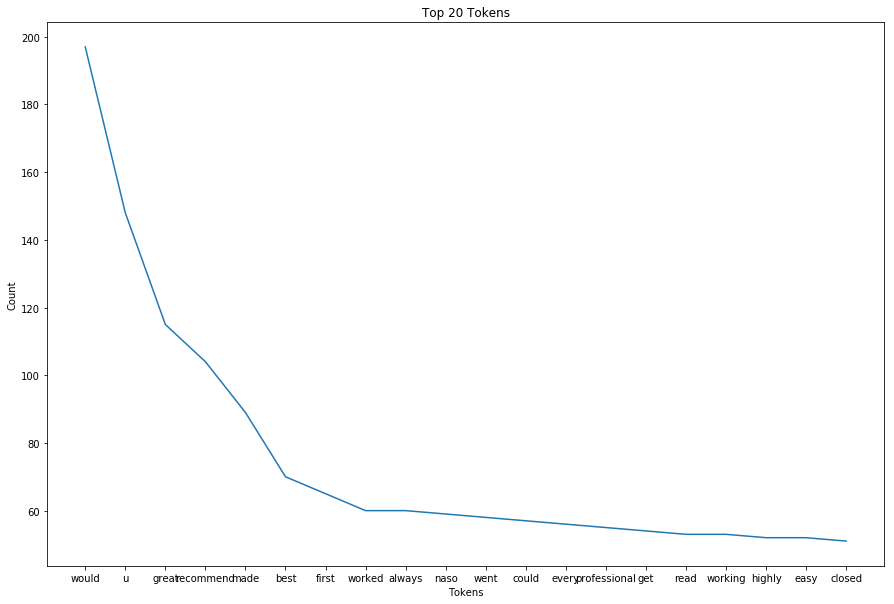

In [19]:
# Counting Words Appearing in a text(a frequency distribution)
top20 = token_count[:20]
plt.figure(figsize=(15,10))
plt.plot('token','count',data=top20)
plt.xlabel('Tokens')
plt.ylabel('Count')
plt.title('Top 20 Tokens')
plt.show()

In [20]:
wordcloud = WordCloud(stopwords=[]).generate(' '.join(X_train.tolist()))

fig = plt.figure(figsize=(50,35))
plt.imshow(wordcloud)

In [21]:
#Classify reviews to positive,negative and neutral
# we use textblob utility to calculate
def get_sentiment(text):
    analysis = TextBlob(text)    # create TextBlob objectof passed text
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'
text = X_train
sentiment = X_train.apply(lambda x: get_sentiment(x))
table = pd.concat([text,sentiment],axis = 1)
column_name = table.columns.values
column_name[1]= 'sentiment'
table.columns = column_name
table.head()

,Reviews,sentiment
216,got done closing even got done get done recomm...,positive
234,increased quoted different different took need...,negative
95,seemed nice first played got interested would ...,positive
54,provided excellent smooth fast would recommend...,positive
313,super responsive thorough next answered prompt...,positive


In [22]:
#Checking Reviews Percentage
positive = table[table.sentiment == 'positive']
print('Positive Reviews Percentage: {} %'.format(100*len(positive)/len(table.Reviews)))
negative = table[table.sentiment == 'negative']
print('negative Reviews Percentage: {} %'.format(100*len(negative)/len(table.Reviews)))
neutral = table[table.sentiment == 'neutral']
print('neutral Reviews Percentage: {} %'.format(100*len(table.Reviews)-len(negative)-len(positive)/len(table.Reviews)))

Positive Reviews Percentage: 87.87128712871286 %
negative Reviews Percentage: 8.168316831683168 %
neutral Reviews Percentage: 40366.12128712871 %


In [23]:
#Checking Top Positive and Negitive Reviews
print("TOP 5 Positive Reviews \n\n",positive.head()['Reviews'].tolist(),'\n')
print("TOP 5 Negative Reviews \n\n",negative.head()['Reviews'].tolist(),'\n')

TOP 5 Positive Reviews 

 ['got done closing even got done get done recommended went great', 'seemed nice first played got interested would file left remained incorrect since maybe said interested straight need help', 'provided excellent smooth fast would recommend first', 'super responsive thorough next answered promptly ben', 'worked sam provide low low detailed introduced wonderful well clear close ahead impressed provided recommend know looking read'] 

TOP 5 Negative Reviews 

 ['increased quoted different different took needed mattered least', 'intake rep nice seemed annoyed bad webster positive hope review get past initial required & required pick selected poor honestly dont would leave blank', 'responsive worked hard u approved distressful really made u like', 'aware critical delayed several finally upon also several later promised pay wrong due late next thomas cordial stayed constant overall incorrect due would make impossible whole', 'lender quite gave needed even pulled neg

### K-Means Cluster Analysis

In [24]:
tf_idf_vectorizor = TfidfVectorizer(max_features=20000)
tf_idf = tf_idf_vectorizor.fit_transform(X_train)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

In [25]:
class Kmeans:
    def __init__(self,k,seed = None,max_iter = 200):
        self.k =k
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
            self.max_iter = max_iter
    def initialise_centroid(self,x):
        
        initial_centroid = np.random.permutation(x.shape[0])[:self.k]
        self.centroid = x[initial_centroid]
        return self.centroid
    def assign_cluster(self,x):
        if x.ndim ==  1:
            x = x.reshape(-1,1)
        dist_to_centroid = pairwise_distances(x,self.centroid,metric = 'euclidean')
        self.cluster_label = np.argmin(dist_to_centroid,axis = 1)
        return self.cluster_label
    def update_centroid(self,x):
        self.centroid = np.array([x[self.cluster_label==i].mean(axis=0) for i in range(self.k)])
        return self.centroid
    def predict(self,x):
        return self.assign_cluster(x)
    def fit_kmeans(self,x):
        self.centroid = self.initialise_centroid(x)
        
        for iter in range(self.max_iter): #main kmeans loop
            self.cluster_label = self.assign_cluster(x)
            self.centroid = self.update_centroid(x)
            if iter % 100 == 0:
                print("Running Model Iteration %d"%iter)
        print('Model finished running')
        return self

[KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=1, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0), KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0), KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0), KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0), KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0), KMeans(algorithm='auto', copy_x=True, init='k-means++', max

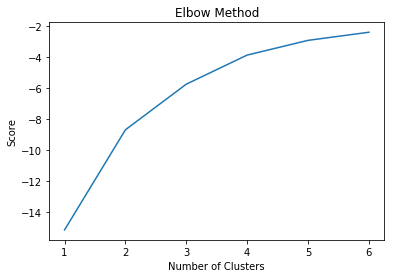

In [26]:
number_cluster = range(1,7)
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = [KMeans(n_clusters=i,max_iter  =600)for i in number_cluster]
print(kmeans)
score  = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
print(score)
plt.plot(number_cluster,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

Running Model Iteration 0
Running Model Iteration 100
Running Model Iteration 200
Running Model Iteration 300
Running Model Iteration 400
Running Model Iteration 500
Model finished running


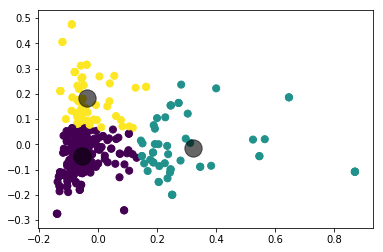

In [27]:
test_e = Kmeans(3,1,600)
fitted = test_e.fit_kmeans(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)
plt.scatter(Y_sklearn[:,0],Y_sklearn[:,1],c=predicted_values,s=50,cmap = 'viridis')
centers = fitted.centroid
plt.scatter(centers[:,0],centers[:,1],c='black', s=300,alpha=0.6)

In [28]:
sklearn_pca= PCA(n_components=3)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters=3,max_iter=600,algorithm='auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

In [29]:
def get_top_features_cluster(tf_idf_array,prediction,n_feats):
    labels = np.unique(prediction)
    dfs= []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp],axis=0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i],x_means[i])for i in sorted_means]
        df = pd.DataFrame(best_features,columns = ['features','score'])
        dfs.append(df)
    return dfs
df1,df2,df3 = get_top_features_cluster(tf_idf_array,prediction,15)
df1

,features,score
0,recommend,0.112927
1,amazing,0.087025
2,naso,0.081158
3,would,0.075974
4,highly,0.075443
5,easy,0.074780
6,definitely,0.066820
7,made,0.051876
8,looking,0.051137
9,first,0.050896


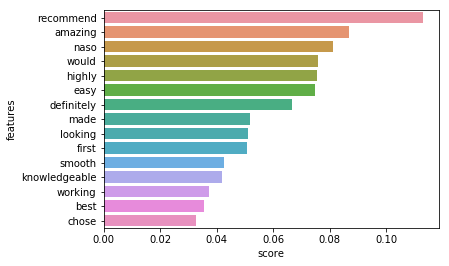

In [30]:
# cluster1 top 15 words
sns.barplot(x = 'score',y = 'features',data = df1)

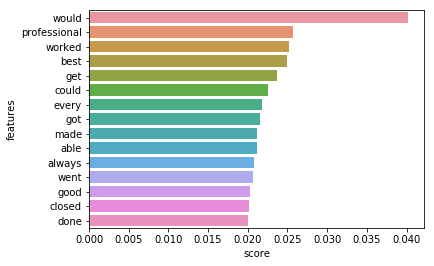

In [31]:
# cluster2 top 15 words
sns.barplot(x = 'score',y = 'features',data = df2)

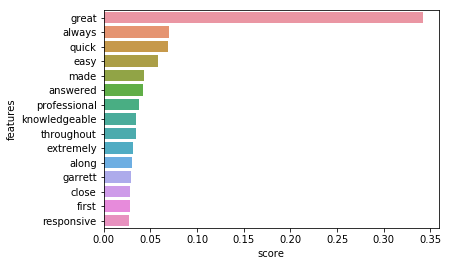

In [32]:
# cluster3 top 15 words
sns.barplot(x = 'score',y = 'features',data = df3)

### Vectorization (count,tfidf) for both train & test(word level tf-idf)

In [33]:
#Train 
count_vect = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',ngram_range=(1,1),min_df=5,encoding='latin-1',max_features=800)
xtrain_count = count_vect.fit_transform(X_train)
tfidf_transformer  = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(xtrain_count)
#Test
xtest_count = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(xtest_count)
dtm2 = pd.DataFrame(X_train_tfidf.toarray(),columns = count_vect.get_feature_names())
dtm2.head()

,able,absolutely,accept,across,adam,additional,agent,ago,agreed,almost,...,whole,within,without,wonderful,worked,working,would,wrong,wyndham,yet
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.143472,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.246786,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


### N-gram generators(n-gram level tf-idf)

In [34]:
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer='word',token_pattern='\w{1,}',ngram_range=(1,2),max_features=800)
tfidf_vect_ngram.fit(X)
xtrain_tfidf_ngram = tfidf_vect_ngram.transform(X_train)
xtest_tfidf_ngram = tfidf_vect_ngram.transform(X_test)

### Character level tf-idf

In [35]:
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern='\w{1,}', ngram_range=(1,2), max_features=800)
tfidf_vect_ngram_chars.fit(X)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_train) 
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_test)

### Topic Modeling

In [36]:
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components=20,learning_method='online',max_iter=50)
X_topics = lda_model.fit_transform(X_train_tfidf)
topic_word = lda_model.components_
vocab = count_vect.get_feature_names()

# Topic Models
n_top_words = 10
topic_summaries = []
for i,topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
topic_summaries

['based said give moving approved talked initial forward next provided',
 'would u best recommend made could great worked highly every',
 'followed financial took felt trying fully another telling also lender',
 'quick great simple thorough guaranteed explaining made helpful honest garrett',
 'able quick friendly pleased need timely said close every first',
 'i u various answered got timely outstanding encountered despite buy',
 'amazing closed naso goodge satisfied chose ca impressed would left',
 'bad tell happier thank beginning dealing wrong steve give highly',
 'good previous responsive contracted professional helpful easy funded four became',
 'fred always around knew best next helped responsive care worked',
 'would every helped easy definitely wanted remained made hold get',
 'called better remained best many agent asked responsive every know',
 'higher explain flex working fine received better minor buying required',
 'informed throughout well kept friendly great together answ

### Creating a function for train models

In [37]:
def train_model(classifier,feature_vector_train,label,feature_vetor_valid,valid_y,is_neutral_net=False):
    classifier.fit(feature_vector_train,label) #fit training dataset on classifier
    predictions = classifier.predict(feature_vetor_valid) #Predict Labels on validation dataset
    
    if is_neutral_net:
        predictions = predictions.argmax(axis=-1)
    return metrics.accuracy_score(predictions,valid_y)

## Naive Bayes

In [38]:
# Naive Bayes on count vector tf-idf
accuracy_L1 = train_model(naive_bayes.MultinomialNB(),X_train_tfidf,y_train,X_test_tfidf,y_test)
print('NB for L1,count vectors: ',accuracy_L1)
# Naive Bayes on Word Level tf-idf
accuracy_L1 = train_model(naive_bayes.MultinomialNB(),xtrain_count,y_train,xtest_count,y_test)
print('NB for L1,Wordlevel vectors: ',accuracy_L1)
# Naive Bayes on Ngram Level tf-idf
accuracy_L1 = train_model(naive_bayes.MultinomialNB(),xtrain_tfidf_ngram,y_train,xtest_tfidf_ngram,y_test)
print('NB for L1,N-Gram vectors: ',accuracy_L1)
# Naive Bayes on Character Level tf-idf
accuracy_L1 = train_model(naive_bayes.MultinomialNB(),xtrain_tfidf_ngram_chars,y_train,xtest_tfidf_ngram_chars,y_test)
print('NB for L1,charlevel vectors: ',accuracy_L1)

NB for L1,count vectors:  0.900990099009901
NB for L1,Wordlevel vectors:  0.9405940594059405
NB for L1,N-Gram vectors:  0.8415841584158416
NB for L1,charlevel vectors:  0.8217821782178217


### Predicting star rating using reviews

In [39]:
from collections import Counter
texts = [review for review in X_train]
stars = [review for review in y_train]

# Balancing the data
def balance_classes(xs,ys):
    """Undersample xs,ys to blalance classes"""
    freqs= Counter(ys)
    max_allowable = freqs.most_common()[-1][1]
    num_added = {clss:0 for clss in freqs.keys()}
    new_ys = []
    new_xs = []
    for i,y in enumerate(ys):
        if(num_added[y]<max_allowable):
            new_ys.append(y)
            new_xs.append(xs[i])
            num_added[y] +=1
    return(new_xs,new_ys)

In [40]:
print(Counter(stars))
balanced_x,balanced_y = balance_classes(texts,stars)
print(Counter(balanced_y))

Counter({5: 327, 1: 77})
Counter({5: 77, 1: 77})


In [41]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectors = vectorizer.fit_transform(balanced_x)

X_train,X_test,y_train,y_test = train_test_split(vectors,balanced_y,test_size = 0.33,random_state = 123)
classifier = LinearSVC() #initialise SVM Classifier
classifier.fit(X_train,y_train) # training Classifier

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [42]:
#predicting train data
train_pred = classifier.predict(X_train)
print(list(train_pred[:10]))
print(y_train[:10])

[1, 1, 5, 5, 5, 5, 1, 5, 5, 1]
[1, 1, 5, 5, 5, 5, 1, 5, 5, 1]


In [43]:
#predicting test data
test_preds = classifier.predict(X_test)
print(list(test_preds[:10]))
print(y_test[:10])

[5, 1, 1, 5, 1, 5, 1, 5, 1, 1]
[5, 5, 1, 5, 1, 5, 1, 5, 1, 1]


In [44]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,test_preds))

0.9411764705882353
